## C. Sentiment Analysis : PART-II

This module talks about the positive sentiments of news articles.

In [1]:
# load required packages/libraries
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
import multiprocessing
import string

nltk.download('wordnet')
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings("ignore")

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from bertopic import BERTopic


2023-05-27 21:43:05.309854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 21:43:08.235249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-27 21:43:08.235379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

#### a) Data Extraction

In [2]:
# Load the dataset
news_pos = pd.read_parquet('positive_dataset.parquet', engine='pyarrow')

# Check the shape of dataset
news_pos.shape

(133165, 12)

In [3]:
news_pos.head(3)

,url,date,language,title,text,cleaned_text,lemmatized_text,num_tokens,token_bucket,sentiment,entities,entity_labels
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,artificial intelligence improves parking effic...,artificial intelligence improves parking effic...,5752,5001-10000,POSITIVE,"[china, china business military world society ...","[GPE, ORG, ORG, GPE, LOC, ORG, ORG, GPE, ORG, ..."
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...",forget ml ai industry obsolescence focus febru...,forget ml ai industry obsolescence focus febru...,13520,10001-15000,POSITIVE,"[dsp, dsp, santos international, london brazil...","[ORG, ORG, ORG, ORG, ORG, GPE, ORG, ORG, ORG, ..."
3,http://www.homeoffice.consumerelectronicsnet.c...,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...,strategy analytics smartphones sold globally a...,strategy analytics smartphones sold globally a...,9490,5001-10000,POSITIVE,"[boston, ville petteri, max samsung, ultra g, ...","[GPE, PERSON, ORG, PERSON, PERSON, GPE, PERSON..."


#### b) Topic Modelling - BERT

In [4]:
# Get the cleaned tokens from the DataFrame
cleaned_tokens = news_pos['lemmatized_text'].tolist()

%time

topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(cleaned_tokens)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11 µs


Batches:   0%|          | 0/4162 [00:00<?, ?it/s]

2023-05-27 21:52:11,086 - BERTopic - Transformed documents to Embeddings
2023-05-27 21:54:40,363 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-27 21:59:44,976 - BERTopic - Clustered reduced embeddings


In [5]:
# Retrieve the top topics and their associated documents
top_topics = topic_model.get_topic_freq().head(100)  
top_topic_ids = top_topics['Topic']

for topic_id in top_topic_ids:
    # Get keywords associated with the current topic
    keywords = topic_model.get_topic(topic_id)
    
    # Retrieve assigned topics for documents
    assigned_topics = topics
    
    # Find representative documents for the current topic
    representative_documents = [i for i, t in enumerate(assigned_topics) if t == topic_id]
    
    # Print the topic ID and its associated keywords
    print(f"Topic {topic_id}: {', '.join([word[0] for word in keywords])}")
    print()


Topic -1: ai, news, data, new, market, gray, technology, intelligence, media, group

Topic 0: ment, cision, products, overview, entertain ment, entertain, resources, services, consumer, general

Topic 1: market, analysis, global, report, growth, players, key, forecast, trends, artificial intelligence

Topic 2: ai, data, business, human, technology, digital, new, intelligence, cloud, news

Topic 3: us, newswires, presswire, ein, ein presswire, us new, releases, south, guinea, north

Topic 4: market, artificial intelligence, artificial, intelligence, report, analysis, growth, global, global artificial, forecast

Topic 5: chatgpt, openai, gpt, chatbot, text, google, like, language, users, model

Topic 6: venturebeat, follow, follow us, vb, venturebeat homepage, us rss, homepage, twitter follow, transform, follow follow

Topic 7: microsoft, bing, openai, chatgpt, windows, search, new, google, tab, new tab

Topic 8: starfilled, data, starfilled starfilled, data science, science, course, pyt

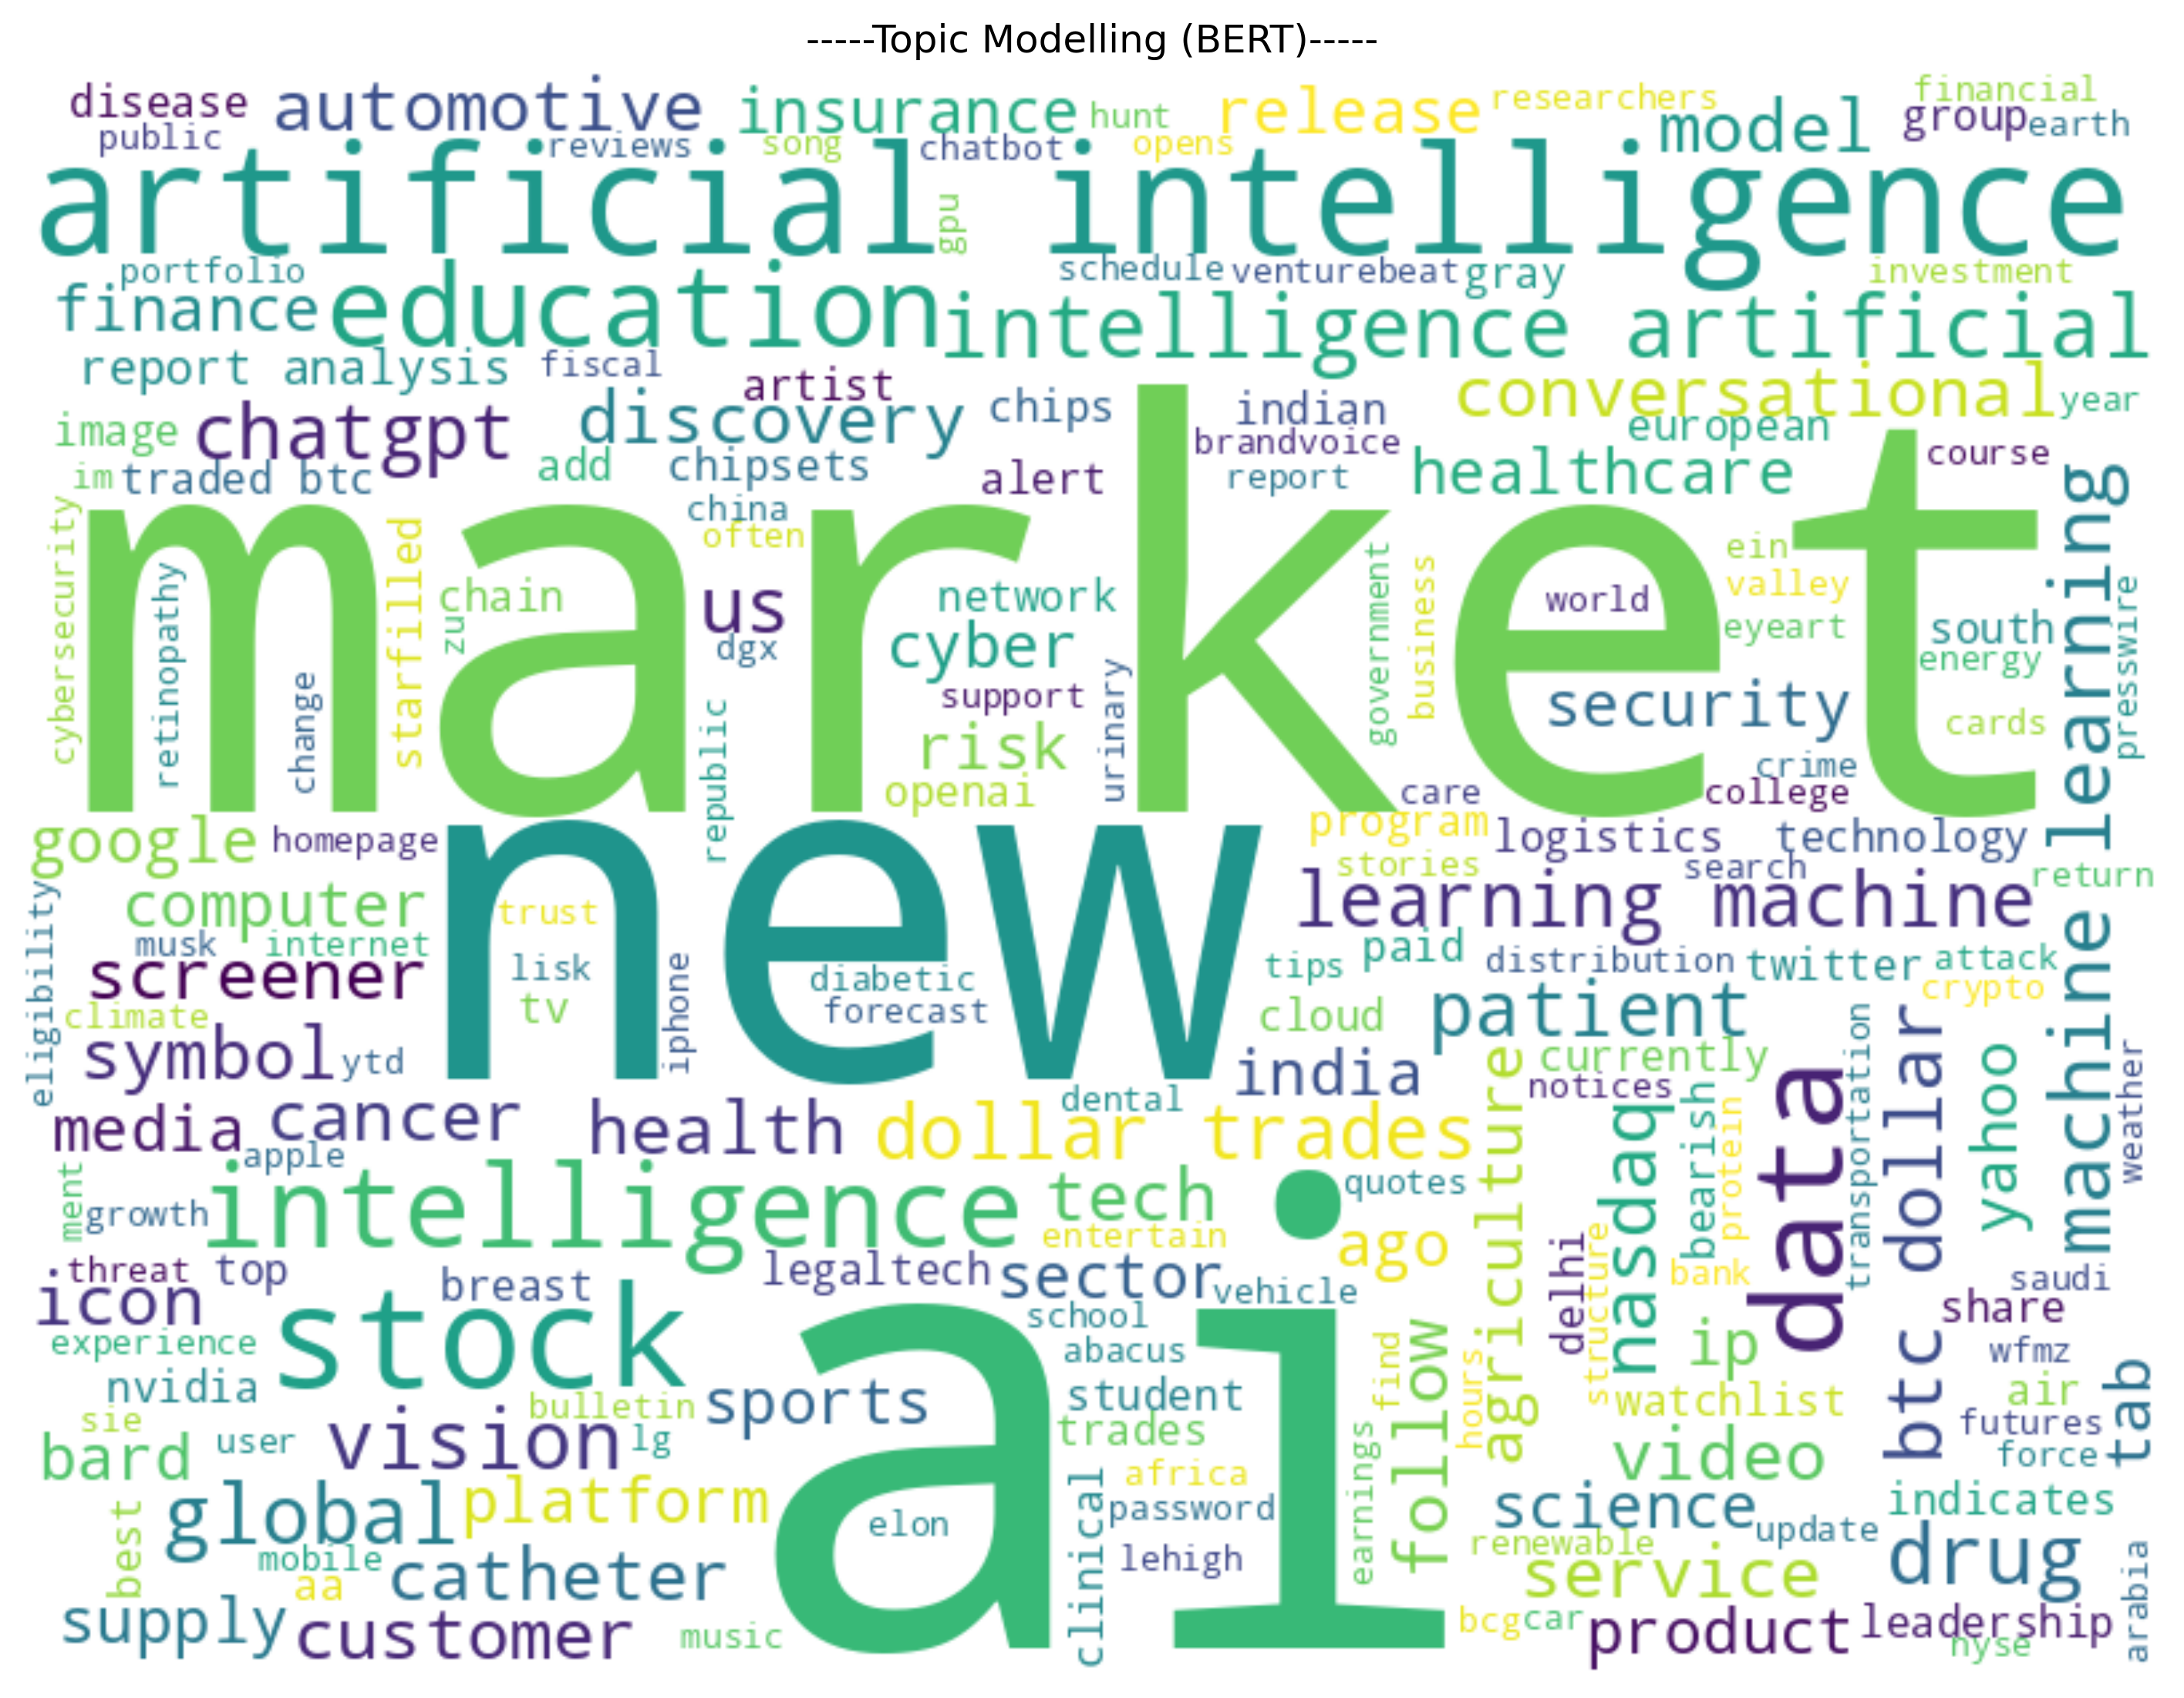

In [6]:
# Concatenate keywords from all topics
all_keywords = []
for topic_id in top_topic_ids:
    keywords = topic_model.get_topic(topic_id)
    all_keywords.extend([word for word, _ in keywords])

# Generate word cloud
wordcloud = WordCloud(background_color='white', width=800, height=600).generate(' '.join(all_keywords))

# Create a figure and set the DPI
fig = plt.figure(figsize=(12, 9), dpi=300)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("-----Topic Modelling (BERT)-----")
plt.axis('off')

# Show the plot with adjusted DPI
fig.set_dpi(300)
plt.show()

In [7]:
news_pos['date'] = pd.to_datetime(news_pos['date']) 
news_pos['quarter'] = news_pos['date'].dt.to_period('Q')


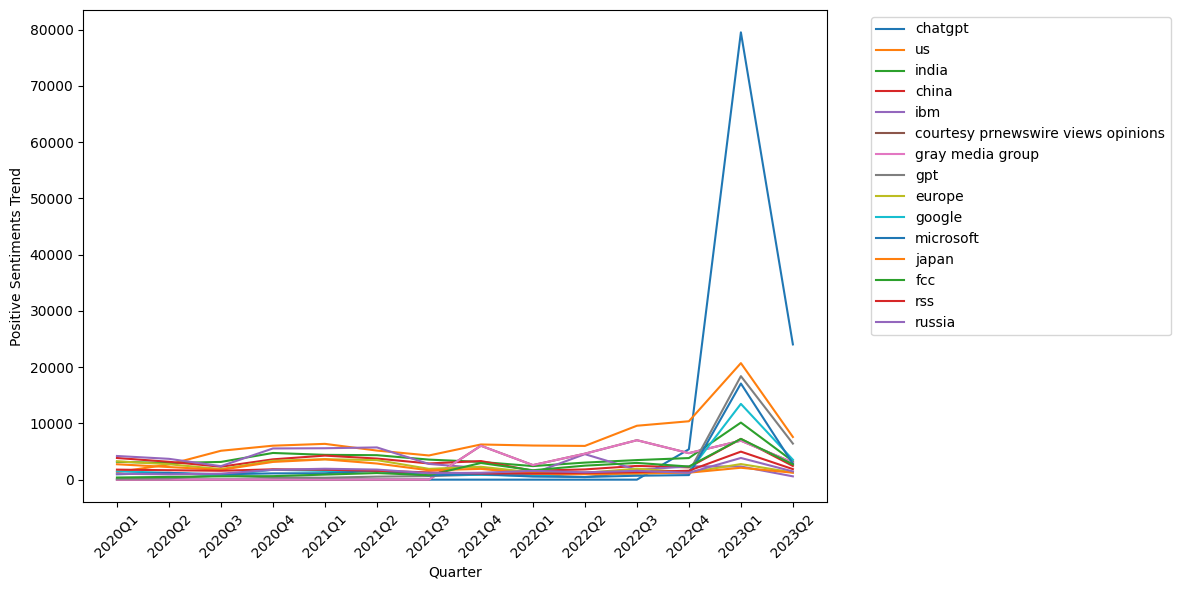

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of entities in the DataFrame
all_entities = [entity for entities in news_pos['entities'] for entity in entities]

# Get the top 10 most common entities
entity_counts = Counter(all_entities)
top_entities = entity_counts.most_common(15)

# Convert top_entities to just a list of entities for ease of use
top_entities = [entity for entity, count in top_entities]

# Store the entity counts by quarter in a dictionary
entity_counts_by_quarter = {entity: {} for entity in top_entities}

for quarter, group in news_pos.groupby('quarter'):
    entities = [entity for entities in group['entities'] for entity in entities]
    quarter_entity_counts = Counter(entities)
    for entity in top_entities:
        entity_counts_by_quarter[entity][quarter] = quarter_entity_counts[entity]

# Prepare the data for plotting
quarterly_entity_counts = pd.DataFrame(entity_counts_by_quarter).fillna(0)

# Plot the quarterly trends for the top 10 entities
plt.figure(figsize=(12,6))  # adjust the size of the plot as needed
for entity in top_entities:
    plt.plot(quarterly_entity_counts.index.astype(str), quarterly_entity_counts[entity], label=entity)

plt.xlabel('Quarter')
plt.ylabel('Positive Sentiments Trend')
plt.xticks(rotation=45)  # rotate the x-axis labels to make them easier to read

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('')
plt.tight_layout()  # adjust the layout to fit the labels
plt.show()

In [9]:
# Filter rows where the 'entities' column contains 'Sam Altman'
filtered = news_pos[news_pos['entities'].apply(lambda entities: 'sam altman' in entities)]

# Get a random sample
random_sample = filtered.sample(10)

random_sample['text']


87353     Musk creates AI company called X.AI to take on...
60412     \n\n \nElon Musk, tech leaders call for halt i...
87178     \n\n\nGenerative AI like ChatGPT is changing t...
18635       Can ChatGPT, GPT-4 be shut down with one swi...
162033    \n\nGoogle Cloud CEO Gives Fiery Rallying Cry ...
111027    \n\n \nElon Musk, tech leaders call for halt i...
131849    Exclusive: Bill Gates On Advising OpenAI, Micr...
150439    \nAn early guide to policymaking on generative...
10742     \n\nSurreal or too real? Breathtaking AI tool ...
105594    \n\nOpenAI: Everything To Know About The Compa...
Name: text, dtype: object

In [10]:
print('-----Some Reasons why ChatGpt is the topmost positive sentiment-----')
print(news_pos['title'][185126])
print(news_pos['title'][112926])
print(news_pos['title'][197763])
print(news_pos['title'][173273])
print(news_pos['title'][5671])
print(news_pos['title'][119926])
print(news_pos['title'][18500])
print(news_pos['title'][148057])
print(news_pos['title'][44190])
print(news_pos['title'][55975])
print(news_pos['title'][92311])

-----Some Reasons why ChatGpt is the topmost positive sentiment-----
OpenAI aims to up the ante in tech industry’s AI race, announces GPT-4 | Deccan Herald
Microsoft to invest more in OpenAI as tech race heats up | Reuters
ChatGPT’s greatest achievement might just be its ability to trick us into thinking that it’s honest | Tech News
Salesforce Announces Einstein Generative AI for CRM - GPT - NCNONLINE
ChatGPT Alternatives You can Try Right Now
Cheaters beware: ChatGPT maker releases AI detection tool
ChatGPT Creator OpenAI Debuts New GPT-4 AI System | Tech News
Thankful Leverages ChatGPT to Lead the AI Customer Service
The AI chatbot that has the whole world in a flutter | Mint
Microsoft in talks to invest $10 billion in ChatGPT owner -Semafor - CNA
ChatGPT: I’m an AI bot who wrote this article to explain how I work


In [11]:
import pandas as pd
import ktrain
from ktrain import text

# Define the keywords
keywords = ['military', 'defense', 'force', 'air force', 'dod', 'air', 'pentagon', 'army', 'department', 'aircraft']

# Filter the records that contain all keywords
filtered_records_military = news_pos[news_pos['text'].apply(lambda txt: all(keyword.lower() in txt.lower() for keyword in keywords))]

# Load a text summarization model
ts = text.TransformerSummarizer()

# Apply text summarization to the filtered records
for text in filtered_records_military['text']:
    summary = ts.summarize(text)
    print("Summarized Text: ", summary)
    print("\n")


Summarized Text:  Nand Mulchandani, acting director of the Department of Defense's (DoD) Joint Artificial Intelligence Center (JAIC), said at the Pentagon the U.S. still has the upper hand in the artificial intelligence competition with foreign adversaries. Bob De Luca, formerly executive director of General Services Administration's (GSA) Information Technology Centers of Excellence, has joined the Federal Deposit Insurance Corporation as deputy chief information officer.


Summarized Text:  Defense Watch: HALO Navy Challenge, JASSM Production, NV5, Parsons Acquisitions, ChatGPT. Sikorsky-Boeing Offered Lower Cost FLRAA Bid, But Army Deemed Proposal ‘Unacceptable’ Greystones Group Acquires IP For Data Analytics Software. MDA Seeks Market Research Preparing For 10-Year SM-3 Upgrade.


Summarized Text:  U.S. Northern Command (NORTHCOM) recently conducted a series of tests known as the Global Information DominanceExperiments, or GIDE. GIDE combined global sensor networks, artificial inte